In [1]:
import pickle
from misc import *
import SYCLOP_env as syc
from RL_brain_b import DeepQNetwork


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import cv2

In [4]:
from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')
images, labels = mnist.load_training()

# some_mnist =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256), interpolation=cv2.INTER_AREA) for uu in images[:20]]           
some_mnistSM =[ cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:20]]           
# some_mnist0p5 =[ 0.5*cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256), interpolation=cv2.INTER_AREA) for uu in images[:20]]    
# some_mnistSM0p5 =[ 0.5*cv2.resize(1.+np.reshape(uu,[28,28]), dsize=(256, 256)) for uu in images[:20]]           


In [11]:
    hp = HP()
    hp.mem_depth=1
    hp.logmode = False
#     recorder = Recorder(n=4)
#     images = read_images_from_path('../video_datasets/liron_images/*.jpg')
#     images = [np.mean(1.0*uu, axis=2) for uu in images]
#     images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]
#     images += read_images_from_path('/home/bnapp/arivkindNet/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=10)
    images = some_mnistSM #+some_mnist + some_mnist0p5 + +some_mnistSM0p5
#     images = images = prep_mnist_sparse_images(10,images_per_scene=20)
#     images = [np.sum(1.0*uu, axis=2) for uu in images]
#     images = [cv2.resize(uu, dsize=(256, 256-64), interpolation=cv2.INTER_AREA) for uu in images]
#     import pickle
#     with open('../video_datasets/liron_images/shuffled_images.pkl','rb') as f:
#         uu = pickle.load(f)
#     images +=uu
    scene = syc.Scene(frame_list=images)
    sensor = syc.Sensor()
    agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

    reward = syc.Rewards()
    observation_size = 64*64
    RL = DeepQNetwork(len(agent.hp.action_space), observation_size,
                      n_features_shaped=list(np.shape(sensor.dvs_view))+[1],
                      shape_fun=lambda x: np.reshape(x,[-1]+list(np.shape(sensor.dvs_view))+[1]),
                      reward_decay=0.99,
                      e_greedy=0.95,
                      e_greedy0=0.8,
                      replace_target_iter=10,
                      memory_size=100000,
                      e_greedy_increment=0.0001,
                      learning_rate=0.0025,
                      double_q=True,
                      dqn_mode=True,
                      state_table=np.zeros([1,observation_size*hp.mem_depth]),
                      soft_q_type='boltzmann',
                      beta=0.5,
                      arch='conv'
                      )




debu: [64, 64, 32]
debu: [32, 32, 16]
debu: [64, 64, 32]
debu: [32, 32, 16]


In [22]:
RL.dqn.load_nwk_param('saved_runs/run_syclop_generic_cnn1.py_noname_1575821205_0/best_liron.nwk')

In [23]:

def local_observer(sensor,agent):
    normfactor=1.0/256.0
    return normfactor*sensor.dvs_view.reshape([-1])

observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
hp.fading_mem = 0.5

In [27]:
RL.beta=1.0

In [28]:
recorders=[]
for image_num,image in enumerate(images):
    recorder = Recorder(n=4)
    step = 0
    episode = 0
    observation = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    observation_ = np.random.uniform(0,1,size=[hp.mem_depth, observation_size])
    scene.current_frame = image_num
    scene.image = scene.frame_list[scene.current_frame]

    agent.reset()
#     agent.q_ana[1]=256./2.-32
#     agent.q_ana[0]=192./2-32
#     agent.q = np.int32(np.floor(agent.q_ana))

    sensor.reset()
    sensor.update(scene, agent)
    sensor.update(scene, agent)
    for step_prime in range(1000):
        action = RL.choose_action(observation.reshape([-1]))
        reward.update_rewards(sensor = sensor, agent = agent)
        recorder.record([agent.q_ana[0],agent.q_ana[1],reward.reward,RL.epsilon])
        agent.act(action)
        sensor.update(scene,agent)
        observation *= hp.fading_mem
        observation += local_observer(sensor, agent)  # todo: generalize
        if step%1000 ==0:
            print(episode,step)
#                 print('frame:', scene.current_frame)
        step += 1
    recorders.append(recorder)



0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


<IPython.core.display.Javascript object>


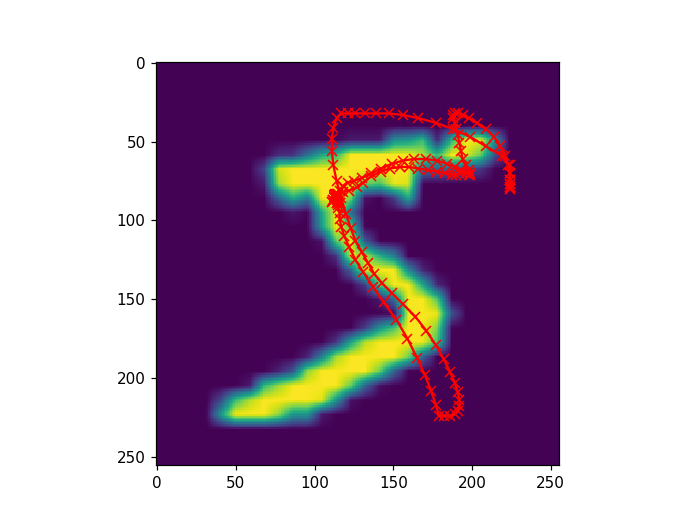

<IPython.core.display.Javascript object>


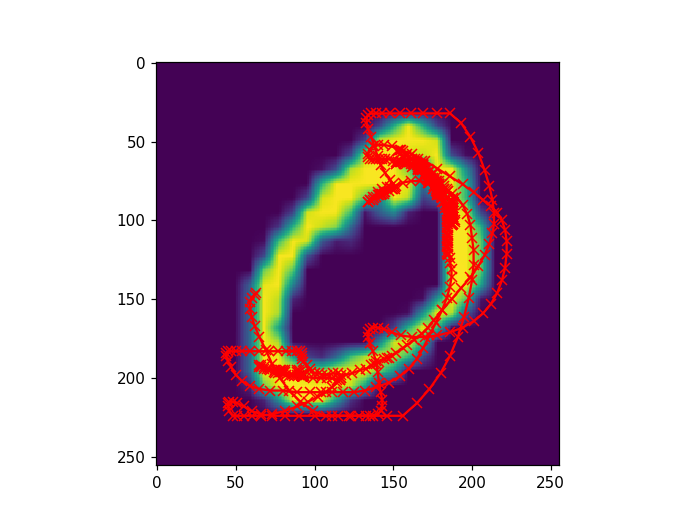

<IPython.core.display.Javascript object>


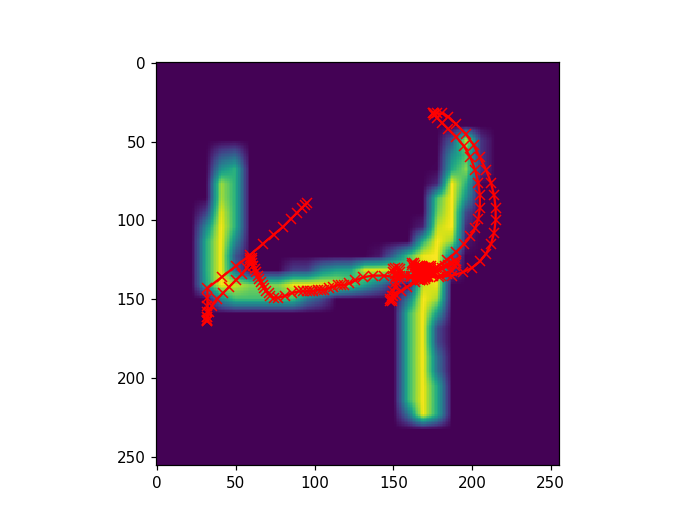

<IPython.core.display.Javascript object>


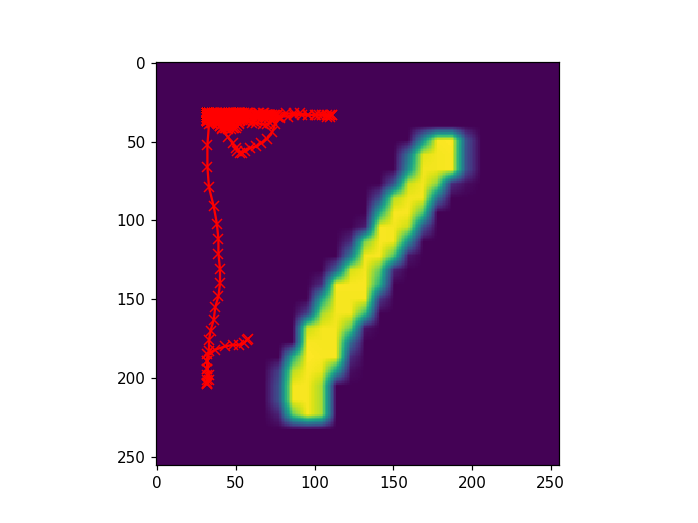

<IPython.core.display.Javascript object>


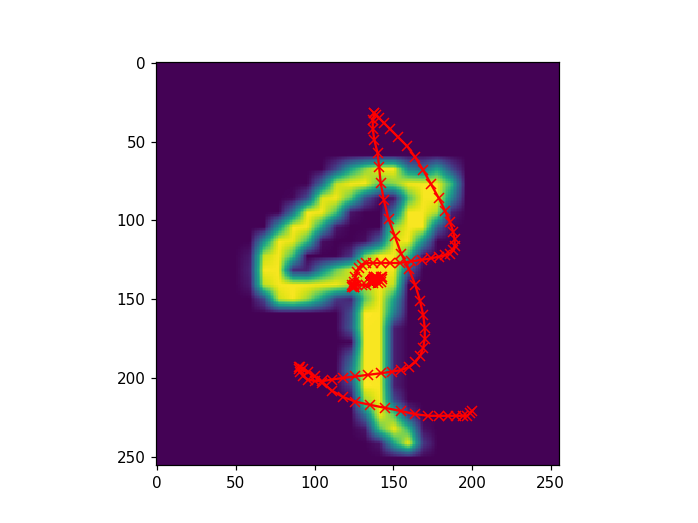

<IPython.core.display.Javascript object>


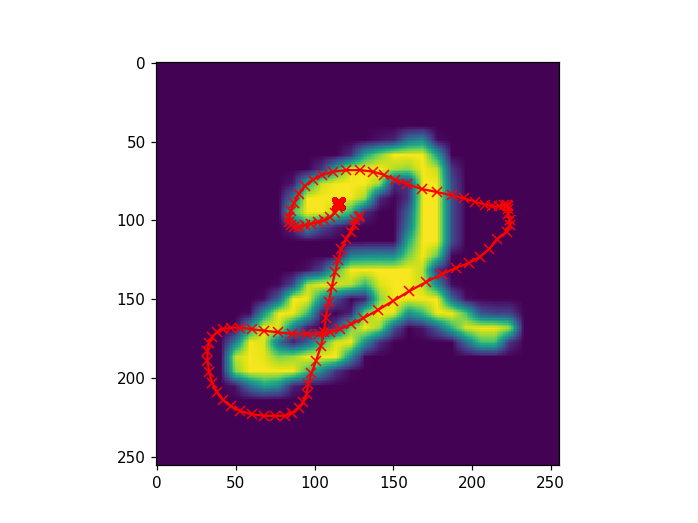

<IPython.core.display.Javascript object>


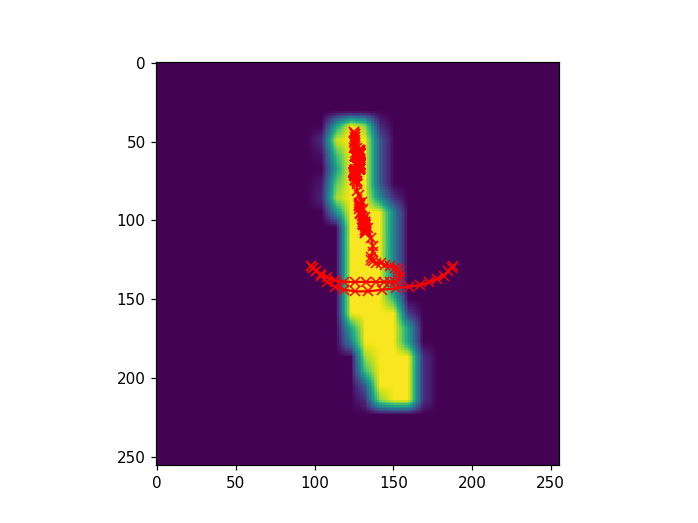

<IPython.core.display.Javascript object>


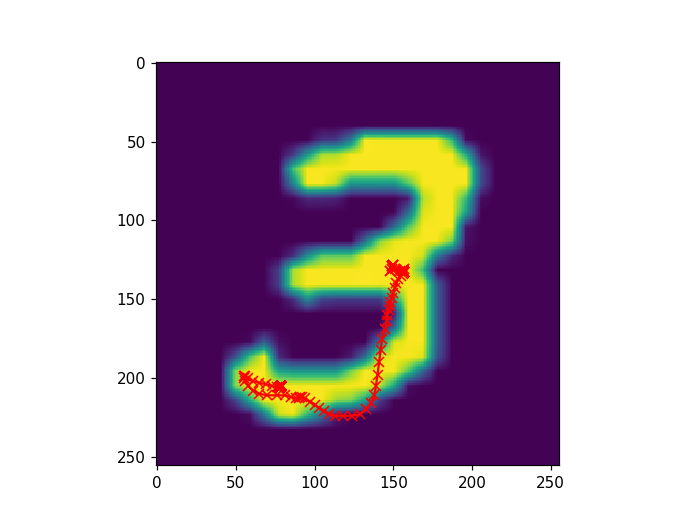

<IPython.core.display.Javascript object>


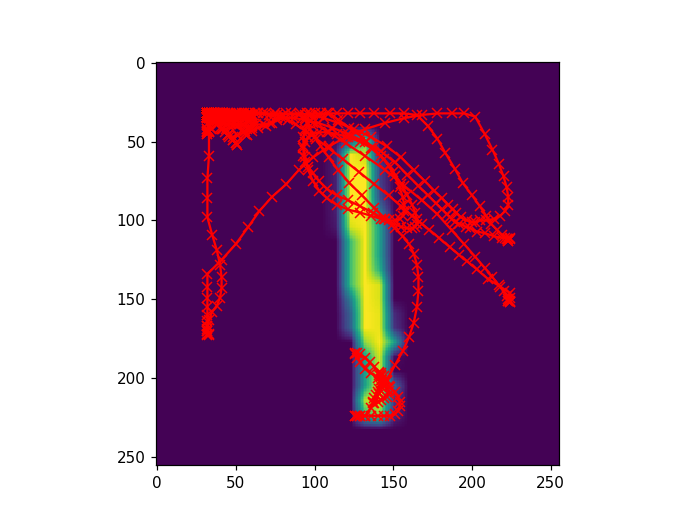

<IPython.core.display.Javascript object>


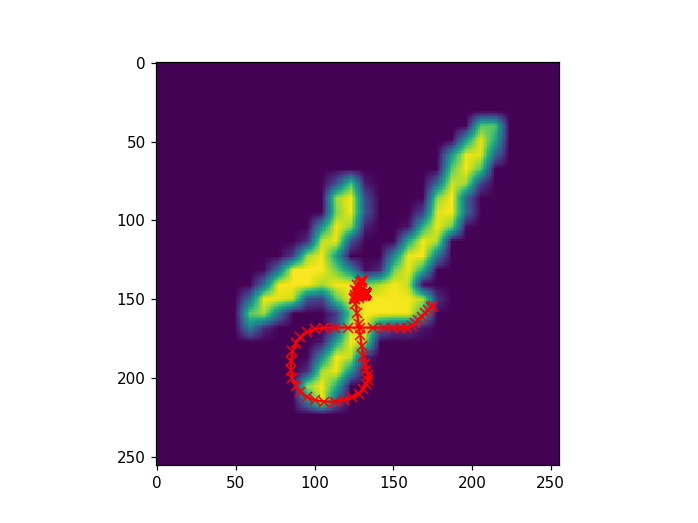

<IPython.core.display.Javascript object>


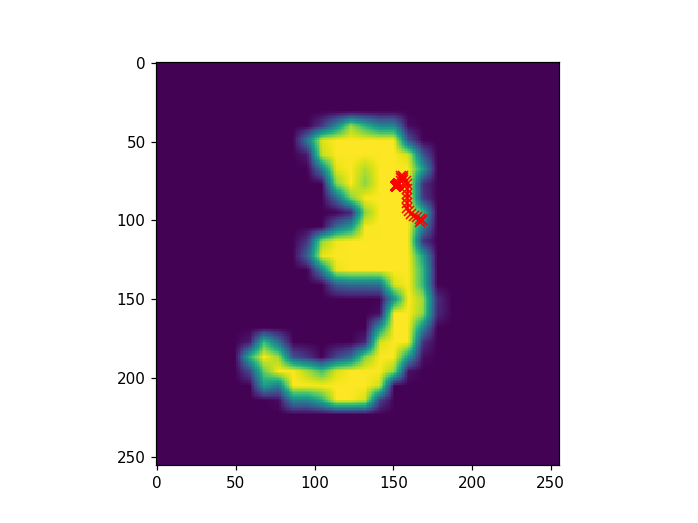

<IPython.core.display.Javascript object>


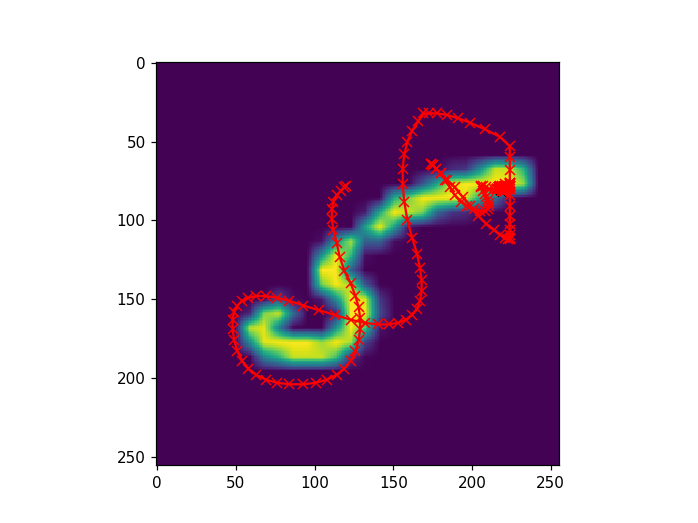

<IPython.core.display.Javascript object>


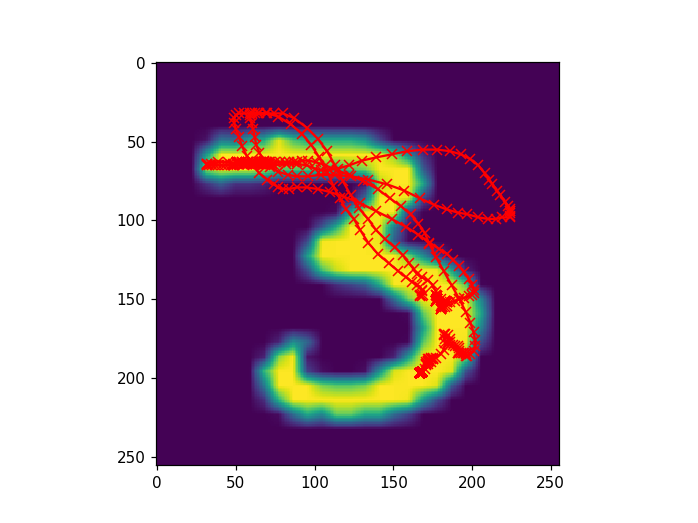

<IPython.core.display.Javascript object>


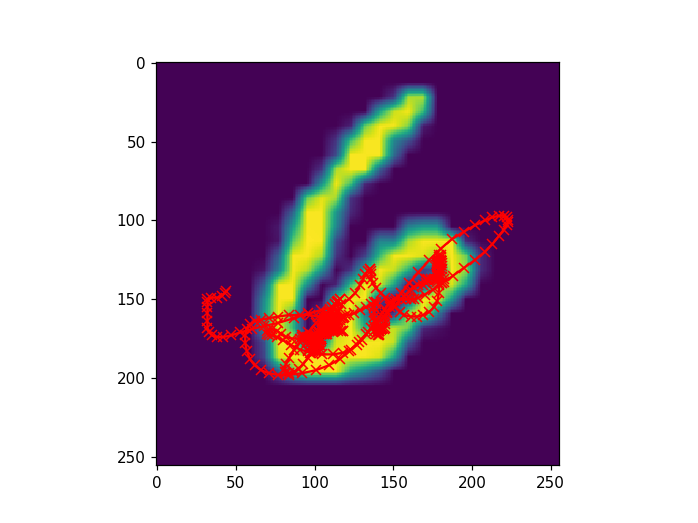

<IPython.core.display.Javascript object>


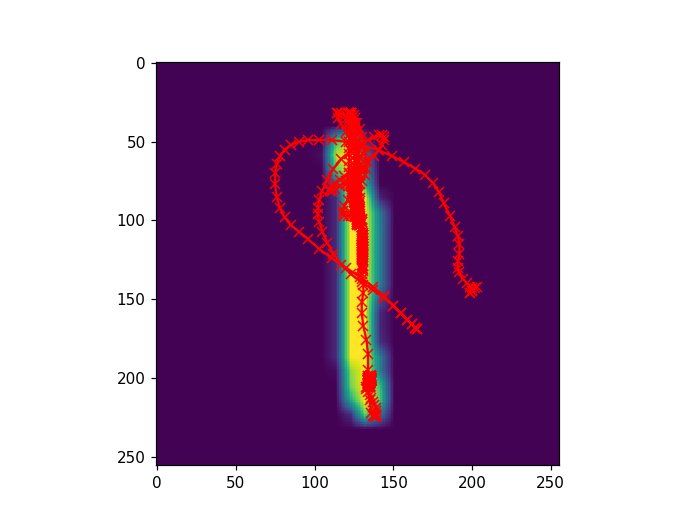

<IPython.core.display.Javascript object>


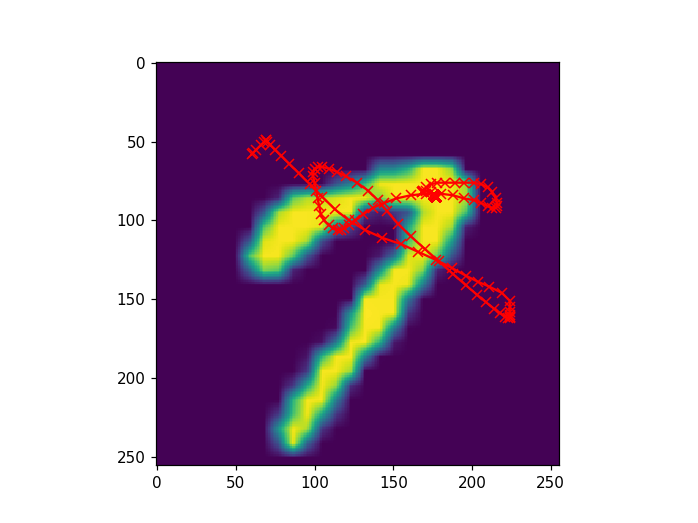

<IPython.core.display.Javascript object>


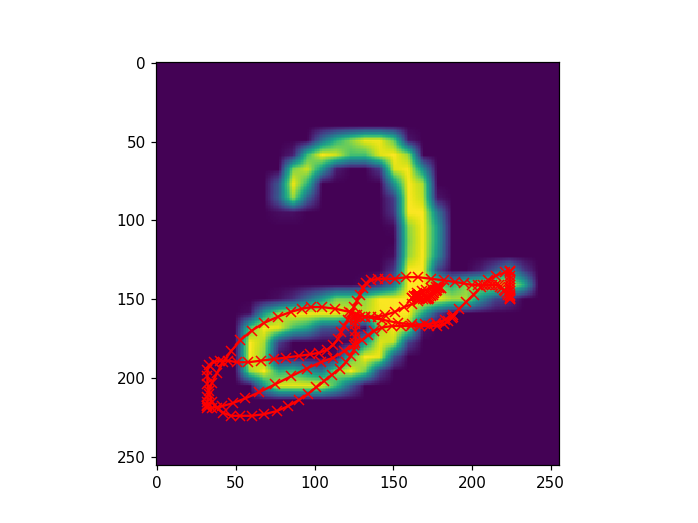

<IPython.core.display.Javascript object>


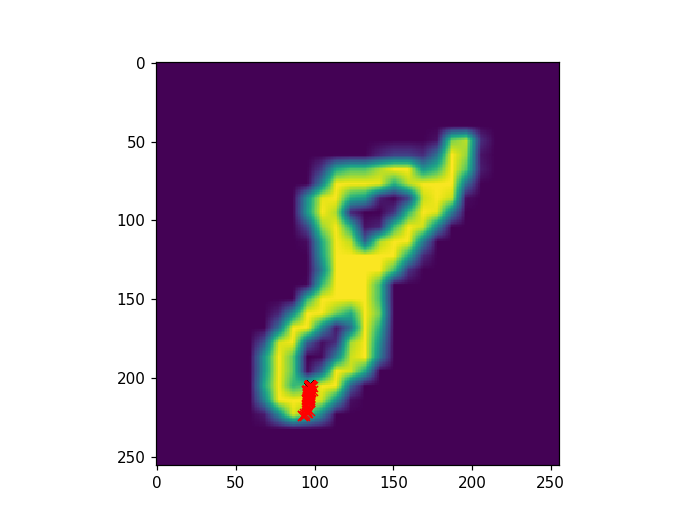

<IPython.core.display.Javascript object>


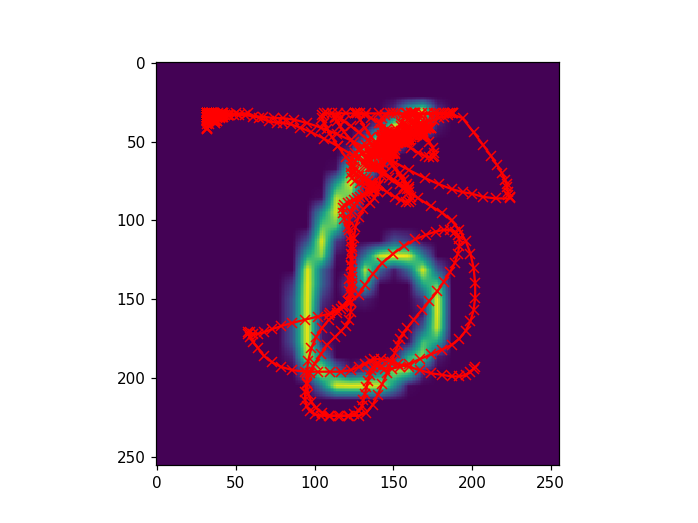

<IPython.core.display.Javascript object>


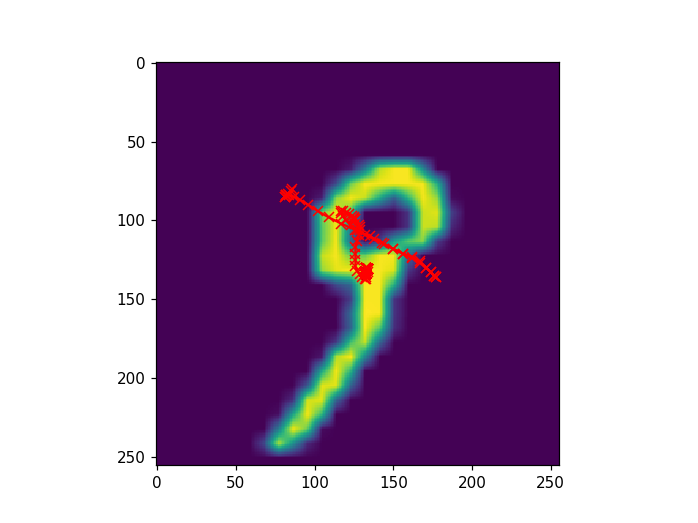

In [29]:
for image,recorder in zip(images,recorders):
    plt.figure()
    plt.imshow(image,vmax=256,vmin=0)
    plt.plot(32+np.array(recorder.records[0]),image.shape[0]-32-np.array(recorder.records[1]),'r-x')



In [11]:
trajectories=[]
for image,recorder in zip(images,recorders):
    trajectories.append([32+np.array(recorder.records[0]),image.shape[0]-32-np.array(recorder.records[1])])

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


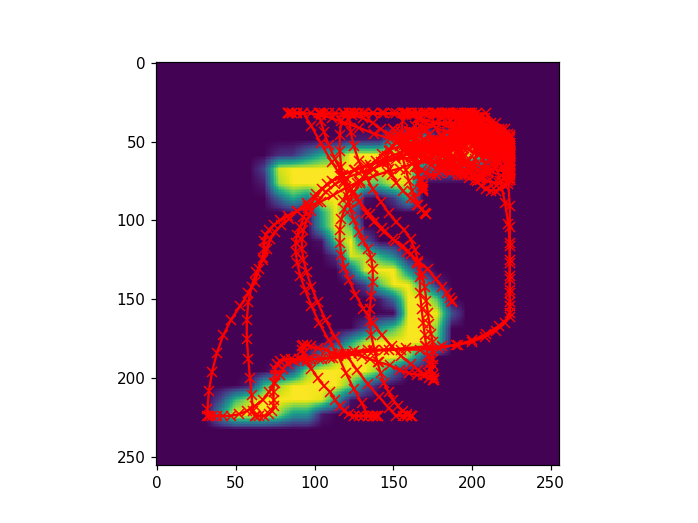

<IPython.core.display.Javascript object>


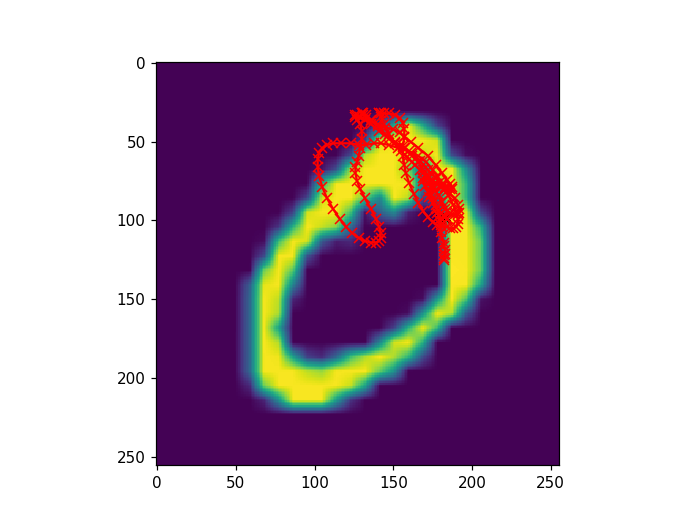

<IPython.core.display.Javascript object>


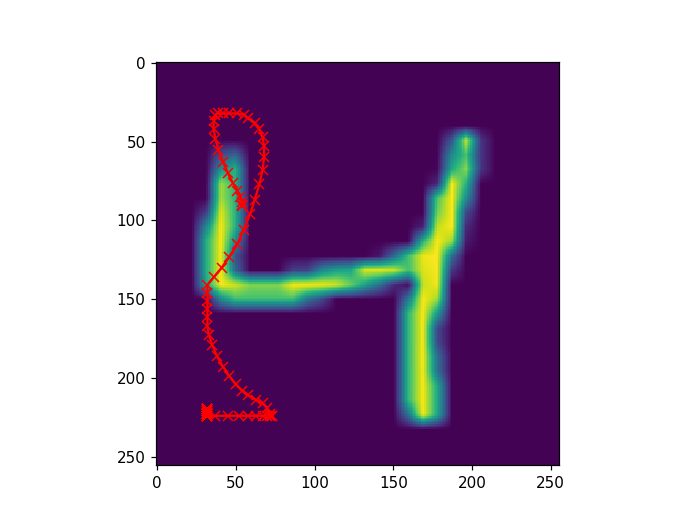

<IPython.core.display.Javascript object>


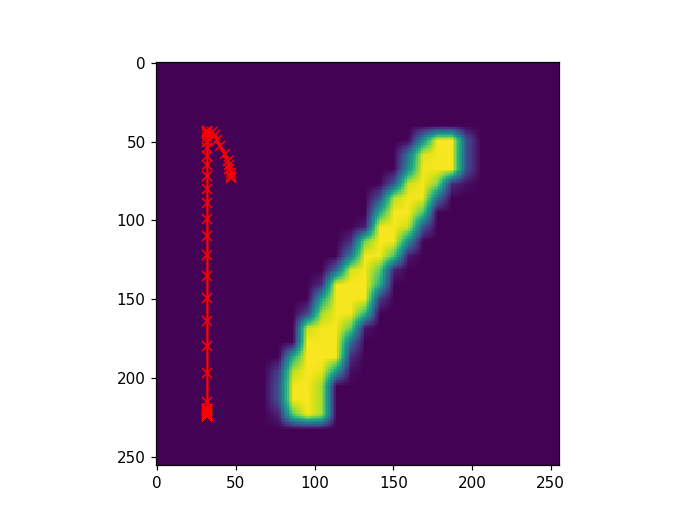

<IPython.core.display.Javascript object>


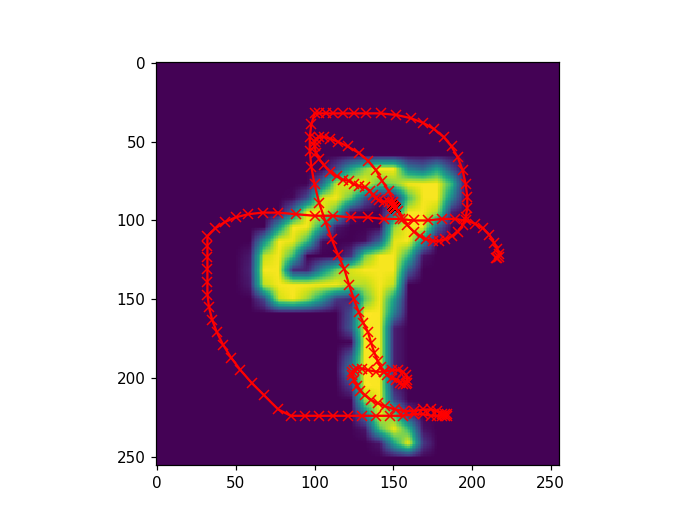

<IPython.core.display.Javascript object>


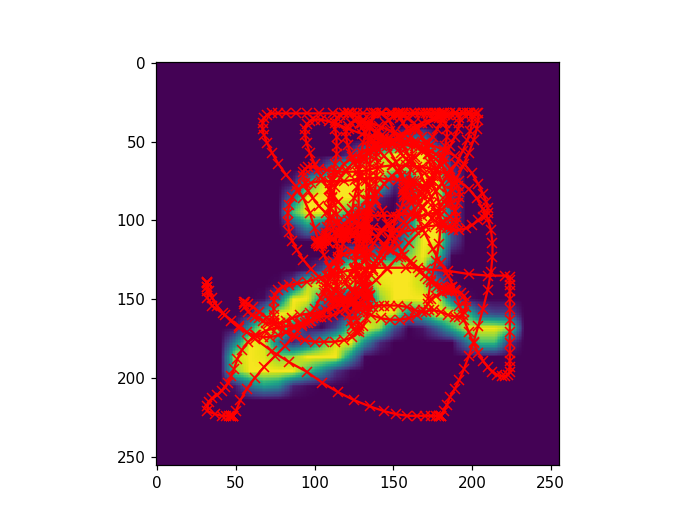

<IPython.core.display.Javascript object>


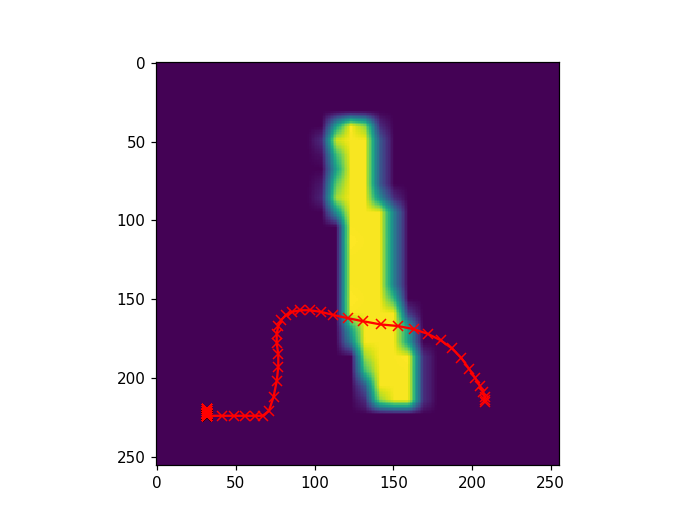

<IPython.core.display.Javascript object>


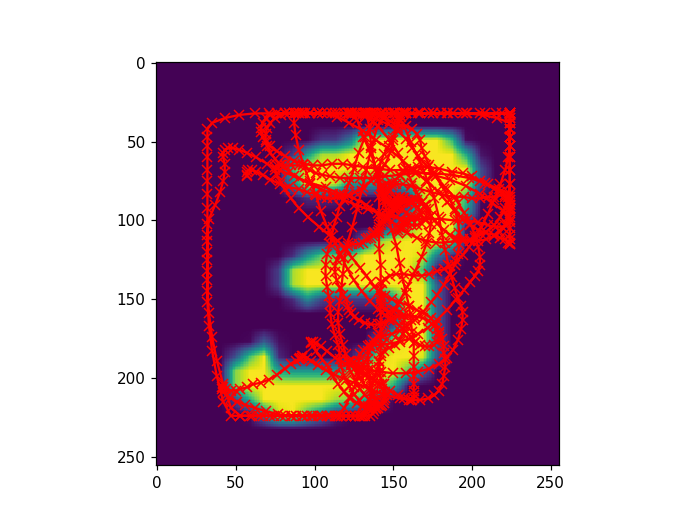

<IPython.core.display.Javascript object>


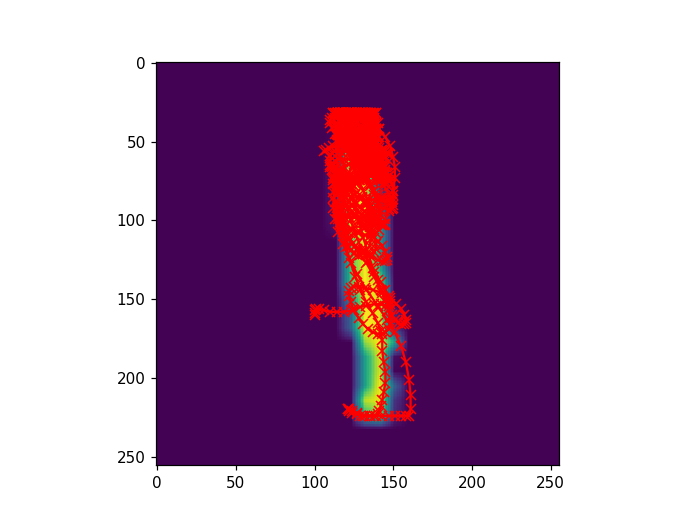

<IPython.core.display.Javascript object>


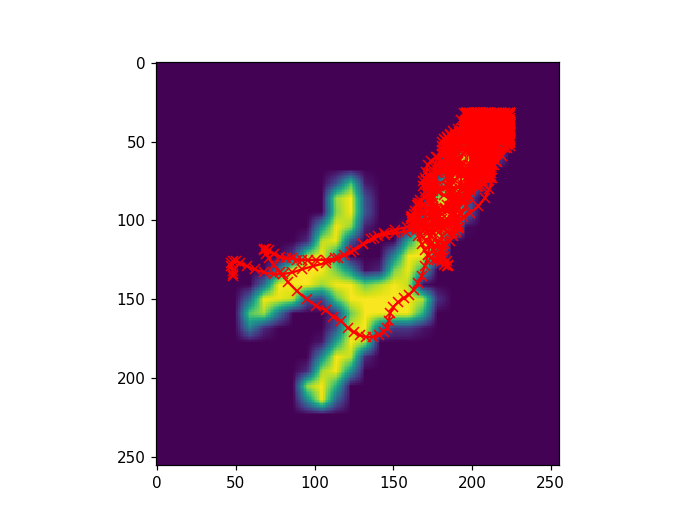

<IPython.core.display.Javascript object>


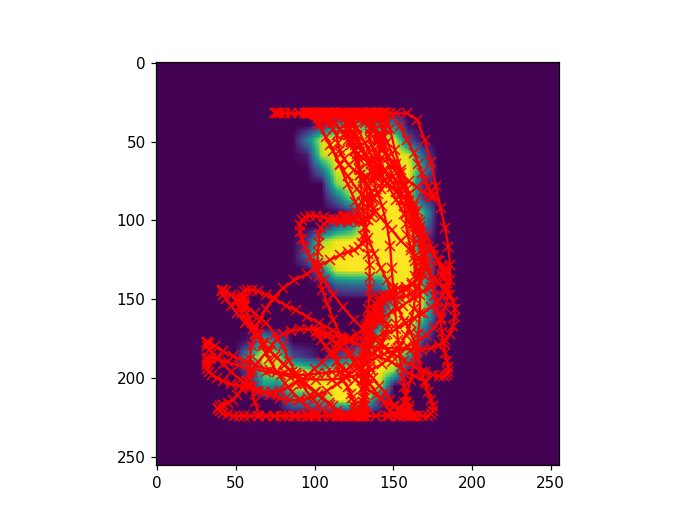

<IPython.core.display.Javascript object>


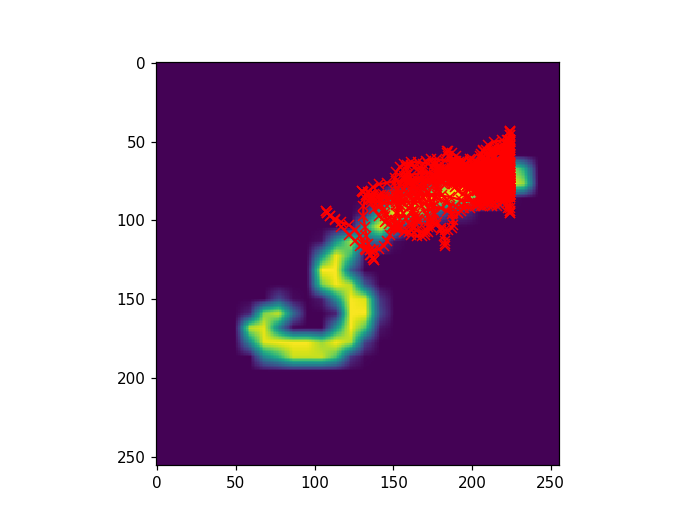

<IPython.core.display.Javascript object>


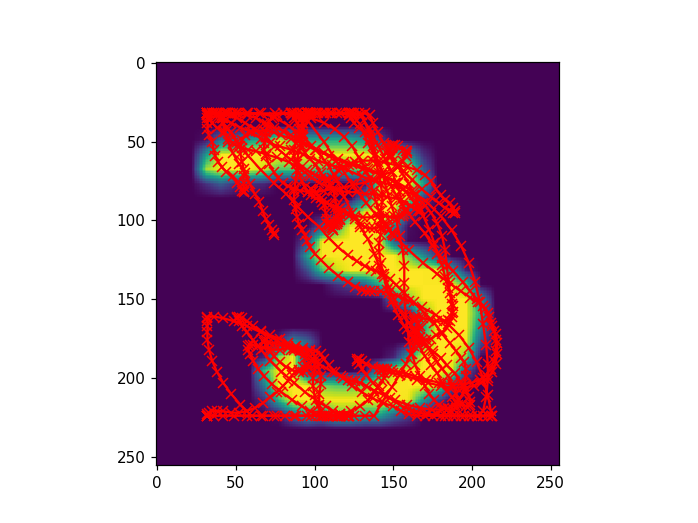

<IPython.core.display.Javascript object>


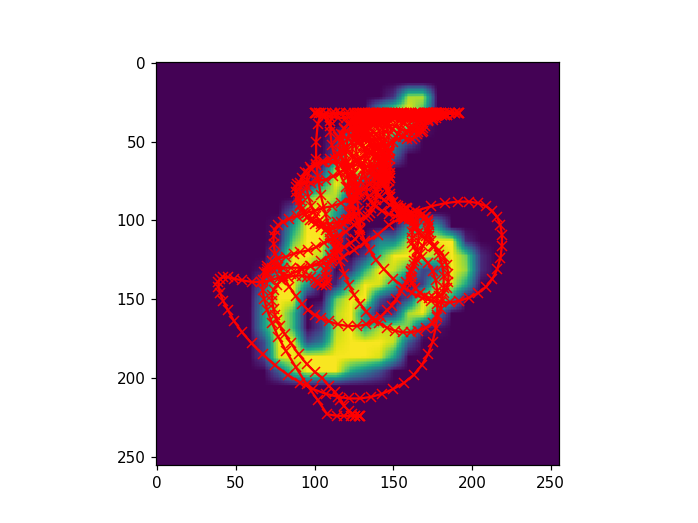

<IPython.core.display.Javascript object>


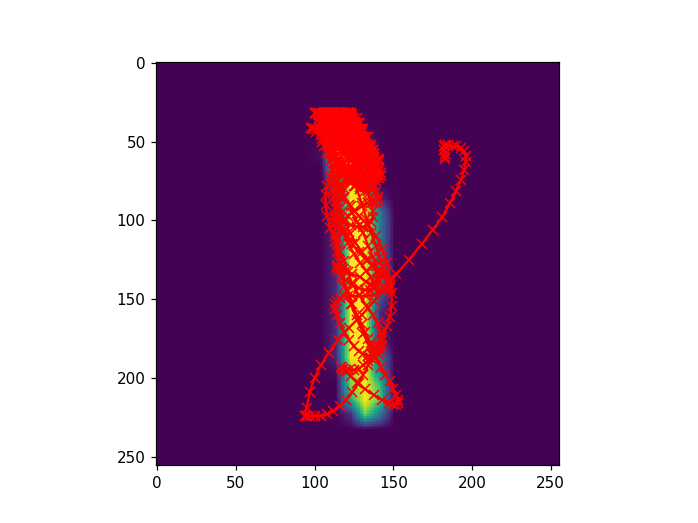

<IPython.core.display.Javascript object>


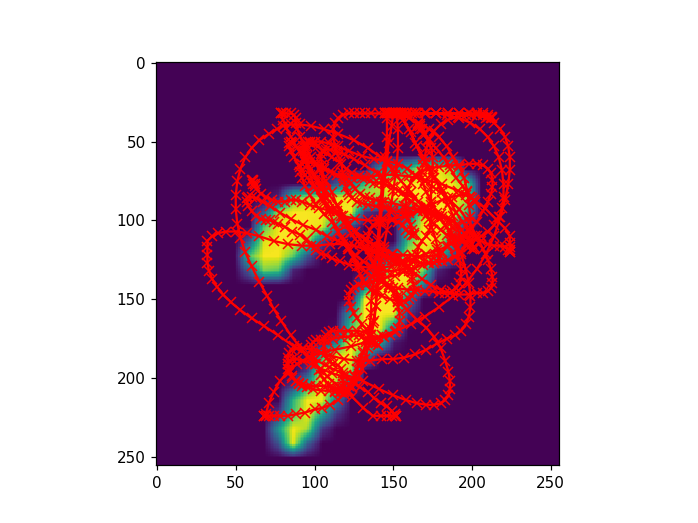

<IPython.core.display.Javascript object>


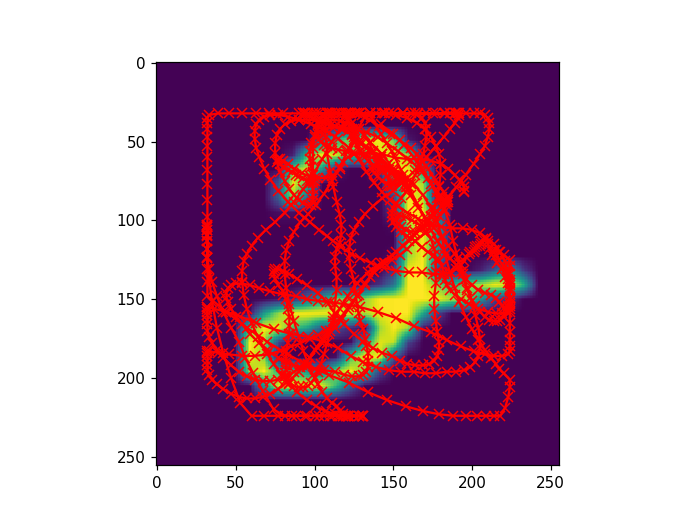

<IPython.core.display.Javascript object>


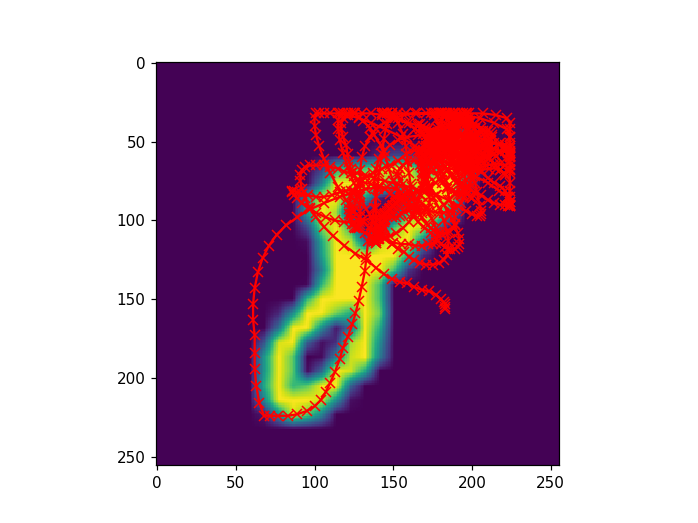

<IPython.core.display.Javascript object>


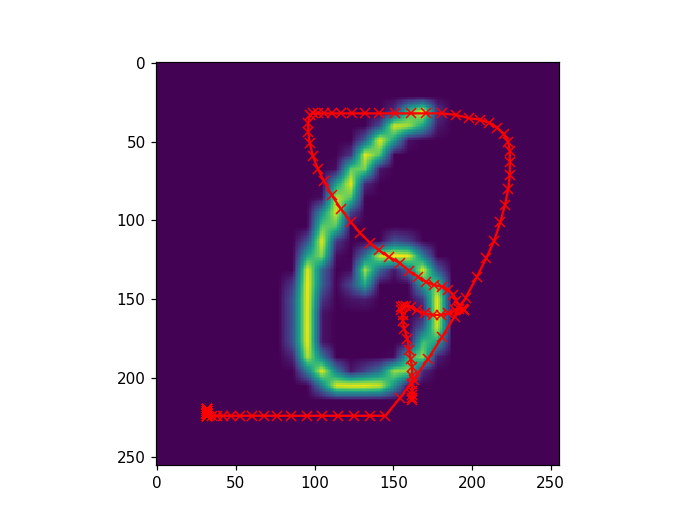

<IPython.core.display.Javascript object>


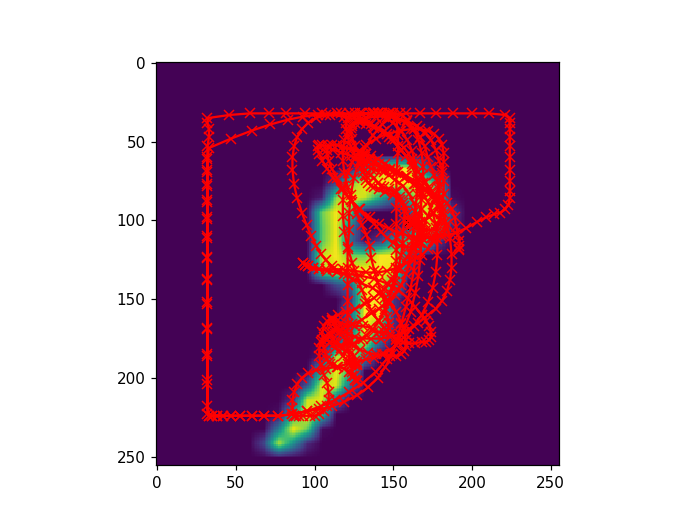

In [12]:
for image,trajectory in zip(images,trajectories):
    plt.figure()
    plt.imshow(image,vmax=256,vmin=0)
    plt.plot(trajectory[0],trajectory[1],'r-x')

In [13]:
with open('image_and_trajectory_examples.pkl','wb') as f:
    pickle.dump([images,trajectories],f)

In [10]:
# RL.dqn.save_nwk_param('liron_encircle.nwk')

In [11]:
# import pickle
# with open('../video_datasets/liron_images/shuffled_images.pkl','rb') as f:
#     uu = pickle.load(f)

In [11]:
run_dir ='saved_runs/run_syclop_generic3.py_noname_156440904369715104/'

In [12]:
with open(run_dir+'/hp.pkl','rb') as f:
          this_hp = pickle.load(f)

In [13]:
this_hp.RL.gamma

0.95

In [14]:
this_hp.fading_mem

0.5

In [15]:
this_hp.reward.relative_weights

[1.0, -5.0]